# OCR Agent from scratch:

* [Data](./Data-Sources.ipynb)
* [Utilities](./Data-Processing.ipynb)
* [Extract layout features and visual tokens](./Data-Extraction-2.ipynb)
* [Generate training data](./Data-Extraction-3.ipynb)
* [Model architecture](./Model-Backbone.ipynb)
* [Traversal strategies](./Traversal-Layout.ipynb)
* Reader Agent
    * Wire language model in
    * [Set RAG utilities](./Agent-RAG.ipynb)
    * [Define FSM](./Agent-FSM.ipynb)
    * [Reinforcement learning setup](./Agent-RL.ipynb)
* [Leverage synthetic training data](./Data-Gen.ipynb)
* [Optimization for production](./Optimization.ipynb)

### Language Model
Our nearsighted agent-reader could use some help from some language model:
* fix misses like word aggregation (space presence) and the characters looking the same (`l,I,1`)
* find next text-block in the case of cross-block text aggregation
* form fields key-value attribution

This language model would be dealing with short sequences and should be local and (preferably) handled by char-level tokenizer. This project has limited vocabulary -- we should be able to build this model easily from scratch. All we need for this agent is to be able to predict the next token to support visual impression, ant predict most probable next word or two to find the next layout block.
Let's train our own `GPT`.

In [1]:
import json
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD, AdamW
from torchsummary import summary
from torchmetrics import ConfusionMatrix

#torch.manual_seed(16)

In [2]:
from scripts.dataset import *
from scripts.training import *

In [3]:
torch.cuda.empty_cache()
print('GPU' if DEVICE == 'cuda' else 'no GPU')

GPU


### Tokenizer
Our class-index build with some extra room targeting online-learning.

In [4]:
''.join(INDEX)

' aeongsitfmpudlcrPbv(h2C1.)xSI-,DyFRA0EB34N5Tq6M7L98wUzOGjk\'H/YéàV•:☐$J%èQêWç?ôZù»+K;▶X◀É"*ûâÀ°&▲«[îÎ]œ=✓#Ô±½@È¼§Êº▼ó>≤ñ!áäìöÂ_¢÷Œ¾ü{ú}©ëåÇí'

In [5]:
class CharacterLevelTokenizer:
    def __init__(self, labels: list):
        vocab = ''.join(labels)
        self.vocab = vocab + '☹' * (len(labels) - len(vocab)) # unknowns at the end
        self.size= len(self.vocab)        
        self.index = { s:i for i, s in enumerate(self.vocab) }
        
    def encode(self, x: str):
        return [self.index[c] if c in self.index else self.index['☹'] for c in x]

    def decode(self, x: list):
        return ''.join([self.vocab[int(x[i])] for i in range(len(x))])


tokenizer = CharacterLevelTokenizer(INDEX)
tokenizer.encode('{ú}©ëåÇí~')

[132, 133, 134, 135, 136, 137, 138, 139, 155]

In [6]:
vocab_size = tokenizer.size
vocab_size

156

### Data
The content of pdf-files as we've seen is not very reliable for spacial layout labeling, but good enough for the text sequence overall.

In [7]:
samples = trainset + testset
len(samples)

8516

In [8]:
    # get some stats on the corpus sequence length
    stats = []
    for source in samples:
        data = pd.read_csv(f'./data/content/{source}.csv.gz')
        stats.append({x:data[data['block-type']==x]['text'].str.len().max() for x in ['word','line','block']})

    pd.DataFrame.from_dict(stats).describe().iloc[1:,:].style.background_gradient()

,word,line,block
mean,22.322100,128.598286,538.922499
std,14.250125,42.524777,399.816025
min,7.000000,19.000000,20.000000
25%,14.000000,97.000000,270.000000
50%,18.000000,131.000000,426.000000
75%,25.000000,161.000000,701.000000
max,180.000000,333.000000,5516.000000


In [9]:
class ContentDataset(Dataset):
    def __init__(self, source: str, labels: list, seq_length: int = 32, level: str = 'word'):
        self.seq_length = seq_length
        self.tokenizer = CharacterLevelTokenizer(labels)
        data = pd.read_csv(f'./data/content/{source}.csv.gz')
        data = data.loc[data['block-type']==level,'text'].astype(str).apply(str.strip).to_list()
        self.data = (' ' if level == 'word' else '\n').join(data)
        
    def __len__(self):
        return len(self.data)
    
    def make_seq(self, i):
        s = list(self.data[i:i + self.seq_length])
        s += [' '] * (self.seq_length - len(s))
        return torch.Tensor(self.tokenizer.encode(s)).long()
    
    def __getitem__(self, idx):
        return self.make_seq(idx), self.make_seq(idx + 1)


In [10]:
source = np.random.choice(testset)

In [11]:
print(source)
D = ContentDataset(source, INDEX)
D.data

irs-f8995ac-0


'SCHEDULE C (Form 8995-A) 2021 Loss Netting and Carryforward Department of the Treasury Internal Revenue Service ▶ Attach to Form 8995-A. ▶ Go to www.irs.gov/Form8995A for instructions and the latest information. OMB No. 1545-2294 Attachment Sequence No. 55D Name(s) shown on return Your taxpayer identification number If you have more than three trades, businesses, or aggregations, complete and attach as many Schedules C as needed. See instructions. 1 ( ) ( ) ( ) Trade, business, or aggregation name (a) Qualified business income/(loss) (b) Reduction for loss netting (see instructions) (c) Adjusted qualified business income (Combine (a) and (b). If zero or less, enter -0-.) 2 Qualified business net (loss) carryforward from prior years. See instructions . . . . . . . . . 2 ( ) 3 Total of the trades, businesses, or aggregations losses. Combine the negative amounts on lines 1, column (a), and 2 for all trades, businesses, or aggregations . . . . . . . . . . . . . . 3 ( ) 4 Total of the trad

In [12]:
for X, Y in DataLoader(D, batch_size=8, shuffle=False):
    for i in range(len(X)):
        print('>>>', tokenizer.decode(X[i].numpy().squeeze()))
        print('<<<', tokenizer.decode(Y[i].numpy().squeeze()))
    break
print('\n', X.shape, Y.shape)

>>> SCHEDULE C (Form 8995-A) 2021 Lo
<<< CHEDULE C (Form 8995-A) 2021 Los
>>> CHEDULE C (Form 8995-A) 2021 Los
<<< HEDULE C (Form 8995-A) 2021 Loss
>>> HEDULE C (Form 8995-A) 2021 Loss
<<< EDULE C (Form 8995-A) 2021 Loss 
>>> EDULE C (Form 8995-A) 2021 Loss 
<<< DULE C (Form 8995-A) 2021 Loss N
>>> DULE C (Form 8995-A) 2021 Loss N
<<< ULE C (Form 8995-A) 2021 Loss Ne
>>> ULE C (Form 8995-A) 2021 Loss Ne
<<< LE C (Form 8995-A) 2021 Loss Net
>>> LE C (Form 8995-A) 2021 Loss Net
<<< E C (Form 8995-A) 2021 Loss Nett
>>> E C (Form 8995-A) 2021 Loss Nett
<<<  C (Form 8995-A) 2021 Loss Netti

 torch.Size([8, 32]) torch.Size([8, 32])


### GPT Model

In [13]:
class AttentionHead(nn.Module):
    def __init__(self, embed_size: int, seq_length: int, head_size: int,
                       dropout: float = 0.5):
        super().__init__()
        self.seq_length = seq_length
        self.embed_size = embed_size
        self.head_size = head_size
        
        self.key   = nn.Linear(self.embed_size, self.head_size, bias=False)
        self.query = nn.Linear(self.embed_size, self.head_size, bias=False)        
        self.value = nn.Linear(self.embed_size, self.head_size, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.register_buffer('tril', torch.tril(torch.ones(self.seq_length, self.seq_length)))        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        b, t, c = x.shape
        K, Q, V = self.key(x), self.query(x), self.value(x)
        W = Q @ K.transpose(-2, -1) * (c ** 0.5)
        W = W.masked_fill(self.tril[:t,:t]==0, float('-inf'))
        W = self.softmax(W)
        W = self.dropout(W)
        return W @ V
    

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size: int, seq_length: int, num_heads: int,
                       dropout: float = 0.5):
        super().__init__()
        self.num_heads = num_heads
        head_size = embed_size // num_heads        
        self.heads = nn.ModuleList([AttentionHead(embed_size, seq_length, head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(embed_size, embed_size)        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = torch.cat([h(x) for h in self.heads], dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x
    

In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size: int, seq_length: int, num_heads: int,
                       expansion: int = 4, dropout: float = 0.5):
        super().__init__()
        self.attn = MultiHeadAttention(embed_size, seq_length, num_heads)
        self.attn_norm = nn.LayerNorm(embed_size)
        self.feed = nn.Sequential(
            nn.Linear(embed_size, embed_size * expansion),
            nn.ReLU(),
            nn.Linear(embed_size * expansion, embed_size),
            nn.Dropout(dropout))
        self.feed_norm = nn.LayerNorm(embed_size)

    def forward(self, x):
        x = x + self.attn(self.attn_norm(x))
        x = x + self.feed(self.feed_norm(x))        
        return x
    

In [16]:
class ContentGPT(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int, seq_length: int,
                       num_heads: int = 8, num_blocks: int = 3):
        super().__init__()        
        self.embed_size = embed_size
        self.seq_length = seq_length        
        self.token_embed = nn.Embedding(vocab_size, embed_size)
        self.pos_embed   = nn.Embedding(seq_length, embed_size)        
        self.blocks = nn.Sequential(
            *[TransformerBlock(embed_size, seq_length, num_heads)] * num_blocks,
            nn.LayerNorm(embed_size) )
        self.lm_head = nn.Linear(embed_size, vocab_size)
        
    def forward(self, x):
        E, P = self.token_embed(x), self.pos_embed(torch.arange(x.shape[1], device=DEVICE))
        return self.lm_head(self.blocks(E + P))
    
    @torch.no_grad
    def get_proba(self, x):
        return nn.functional.softmax(self(x)[0,-1, :], dim=-1)
    
    @torch.no_grad
    def generate(self, x, total, num_samples=1):
        output = []
        for _ in range(num_samples):
            h = x
            for _ in range(total):
                context = h[:,-self.seq_length:]
                logits= self(context)[:,-1,:]
                proba = nn.functional.softmax(logits, dim=-1)
                h = torch.cat((h, torch.multinomial(proba, num_samples=1)), dim=1)
            output.append(h)
        return output
    
    @torch.no_grad
    def get_top_k(self, x, k: int = 10, length: int = 5):
        proba = self.get_proba(x)
        top_k = torch.topk(proba, k).indices
        h = [torch.cat((x, top_k[i].reshape((1, 1))), dim=1) for i in range(k)]
        p = proba[top_k.tolist()]
        for _ in range(length):
            for i in range(k):
                proba = self.get_proba(h[i])
                top = torch.topk(proba, 1).indices
                h[i] = torch.cat((h[i], top.reshape((1, 1))), dim=1)
                p[i] *= proba[top.item()]
        return h, p.cpu().numpy()


### Training

In [17]:
class ContentLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, logits, targets):
        b, t, c = logits.shape
        return self.loss(logits.view(b * t, c), targets.view(b * t))


In [18]:
embed_size = 128
seq_length = 128

model = ContentGPT(vocab_size, embed_size, seq_length, num_heads).to(DEVICE)

In [19]:
model(X.to(DEVICE)).shape

torch.Size([8, 32, 156])

In [20]:
PATH = f'GPT-{embed_size}-{vocab_size}-{seq_length}'
model.load_state_dict(torch.load(f'./models/{PATH}.pt'))

<All keys matched successfully>

In [21]:
criterion = ContentLoss()
#criterion.load_state_dict(torch.load(f'./models/{PATH}-criterion.pt'))

In [22]:
criterion(model(X.to(DEVICE)), Y.to(DEVICE))

tensor(2.0696, device='cuda:0', grad_fn=<NllLossBackward0>)

In [23]:
learning_rate = 1e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)
#optimizer.load_state_dict(torch.load(f'./models/{PATH}-optimizer.pt'))

In [24]:
def training_step(model, optimizer, criterion, X, Y):            
    # pass forward
    with torch.cuda.amp.autocast(enabled=False):
        loss = criterion(model(X.to(DEVICE)), Y.to(DEVICE))
        if torch.isnan(loss):
            raise Exception('Loss went baNaNas...')
    # backp-prop
    optimizer.zero_grad()
    scaler.scale(loss).backward()    
    scaler.step(optimizer)
    scaler.update()
    return float(loss.item())


def train(model, dataset, criterion, optimizer, batch_size):
    model.train()
    criterion.train()
    history = []
    loader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    for X, Y in loader:
        history.append(training_step(model, optimizer, criterion, X, Y))
    torch.cuda.empty_cache()
    return history


@torch.no_grad()
def validate(model, dataset, criterion, batch_size):
    model.eval()
    criterion.eval()
    history = []
    loader = DataLoader(dataset, batch_size=batch_size)
    for X, Y in loader:
        loss = criterion(model(X.to(DEVICE)), Y.to(DEVICE))
        history.append(float(loss.item()))
    return history


In [25]:
batch_size = 128
epochs = 5
start = 1

history = {'train':[],'test':[]}
for epoch in range(start, epochs + 1):
    for i, source in enumerate(np.random.permutation(trainset), 1):
        train_history = train(model, ContentDataset(source, INDEX),
                              criterion, optimizer, batch_size=batch_size)
        test_history = validate(model, ContentDataset(np.random.choice(testset), INDEX),
                                criterion, batch_size=batch_size)
        # track epoch avg loss
        history['train'].append(np.mean(train_history))
        history['test'].append(np.mean(test_history))
        print(f"Epoch {epoch}: {i/len(trainset):<7.2%}  "
              f"train: {history['train'][-1]:<5.4f}  "
              f"test: {history['test'][-1]:<5.4f}  "
              , end='\r')

    torch.save(model.state_dict(), f'./models/{PATH}.pt')
    with open(f'./output/{PATH}-{epoch}.json','w') as output:
        json.dump(history, output)
        history = {'train':[],'test':[]}

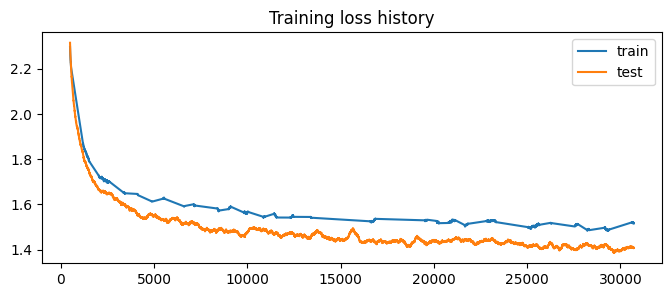

10 tokens:  (Form 4563-T10
20 tokens:  (Form 840 (a) In - ying 
30 tokens:  (For Courcial ☹ Vous avous name 50


In [26]:
#torch.save(optimizer.state_dict(), f'./models/{PATH}-optimizer.pt')
#torch.save(criterion.state_dict(), f'./models/{PATH}-criterion.pt')

train_history, test_history = [], []
for path in sorted([str(x) for x in Path('./output').glob(f'{PATH}*.json')],
                   key=lambda x:int(x.split('-')[-1][:-len('.json')])):
    with open(path) as source:
        h = json.load(source)
        train_history += h['train']
        test_history += h['test']

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(pd.Series(train_history).rolling(500).mean().dropna(), label='train')
ax.plot(pd.Series(test_history).rolling(500).mean().dropna(), label='test')
ax.set_title('Training loss history')
plt.legend()
plt.show()
#plt.savefig(f"./output/{PATH}-{epoch}.png")

start_context = '(For'
encoded = torch.Tensor([tokenizer.encode(start_context)]).long().to(DEVICE)

for length in [10, 20, 30]:
    output = model.generate(encoded, total=length)
    text = tokenizer.decode(output[0][0])
    print(f'{length} tokens:  {text}')

In [27]:
# generate 5 samples 1o tokens total each given `(For` starter context
output = model.generate(encoded, total=10, num_samples=5)
for x in output:
    text = tokenizer.decode(x[0])
    print(text)

(Form 1010 to 
(Form 1064-SCI
(Form. Appelt 
(Form mation. 
(Form 208227 .


In [28]:
# get top 5 probable 3 tokens each given `(For` starter context
output, proba = model.get_top_k(encoded, k=5, length=3)
for i in np.argsort(proba)[::-1]:
    text = tokenizer.decode(output[i][0])
    print(f'{text}   proba: {proba[i]:.6f}')

(Form 10   proba: 0.104362
(For mon   proba: 0.003423
(Fore in   proba: 0.001619
(Forniti   proba: 0.000603
(Forcert   proba: 0.000143
